In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_path = "/content/drive/MyDrive/Datasets/dataset-aedes.zip"

import zipfile

extract_path = "/content/dataset_aedes"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Extraído para:", extract_path)



✅ Extraído para: /content/dataset_aedes


In [ ]:
import os

extract_path = "/content/dataset_aedes/dataset-aedes"

# Listar subpastas (classes)
subpastas = [pasta for pasta in os.listdir(extract_path) if os.path.isdir(os.path.join(extract_path, pasta))]

print("📂 Subpastas (classes) encontradas:")
for pasta in subpastas:
    print(" -", pasta)


📂 Subpastas (classes) encontradas:
 - Ae-albopictus
 - Ae-aegypti


In [ ]:
import tensorflow as tf

# Caminho das imagens
dataset_path = "/content/dataset_aedes/dataset-aedes"

# Carregar dataset com as duas classes
dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    image_size=(224, 224),
    batch_size=32,
    label_mode='int',
    shuffle=True,
    seed=123
)


Found 19008 files belonging to 2 classes.


In [ ]:
import os
import shutil
import uuid

base_path = "/content/dataset_aedes/dataset-aedes"

for classe in os.listdir(base_path):
    classe_path = os.path.join(base_path, classe)
    if os.path.isdir(classe_path):
        for raiz, _, arquivos in os.walk(classe_path):
            for arquivo in arquivos:
                if arquivo.lower().endswith(('.jpg', '.jpeg', '.png')):
                    origem = os.path.join(raiz, arquivo)
                    # Gerar novo nome único
                    novo_nome = f"{uuid.uuid4().hex}_{arquivo}"
                    destino = os.path.join(classe_path, novo_nome)
                    try:
                        shutil.move(origem, destino)
                    except:
                        pass


In [ ]:
import os

# Caminho das classes
dataset_path = "/content/dataset_aedes/dataset-aedes"

# Lista as subpastas
subpastas = [pasta for pasta in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, pasta))]

print("📊 Quantidade de imagens por classe:")
for pasta in subpastas:
    caminho_classe = os.path.join(dataset_path, pasta)
    arquivos = [arq for arq in os.listdir(caminho_classe) if arq.lower().endswith(('.jpg', '.jpeg', '.png'))]
    print(f" - {pasta}: {len(arquivos)} imagens")


📊 Quantidade de imagens por classe:
 - Ae-albopictus: 8866 imagens
 - Ae-aegypti: 10142 imagens


In [ ]:
import tensorflow as tf
from keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

dataset_path = "/content/dataset_aedes/dataset-aedes"
img_size = (128, 128)
batch_size = 32
num_classes = 2

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_dataset = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=123
)

val_dataset = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=123
)


Found 15207 images belonging to 2 classes.
Found 3801 images belonging to 2 classes.


In [ ]:
def build_model(hp):
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(128, 128, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False

    model = models.Sequential()
    model.add(tf.keras.layers.Rescaling(1./127.5, offset=-1))  # Normalização para MobileNet [-1,1]
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())

    # Camada densa customizável
    model.add(layers.Dense(
        hp.Int('dense_units', 64, 256, step=64),
        activation='relu'
    ))
    model.add(layers.Dropout(hp.Float('dropout', 0.2, 0.5, step=0.1)))

    # Saída para classificação binária (one-hot)
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compilação
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', [1e-3, 5e-4, 1e-4])
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [ ]:
import tensorflow as tf
from keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import collections
import numpy as np
import os

# Caminho para o dataset
dataset_path = "/content/dataset_aedes/dataset-aedes"

# Parâmetros
img_size = (224, 224)
batch_size = 32
num_classes = 2

#Verificar a quantidade de imagens por classe
print("Quantidade de imagens por classe:")
for classe in os.listdir(dataset_path):
    caminho = os.path.join(dataset_path, classe)
    if os.path.isdir(caminho):
        num_imgs = len([f for f in os.listdir(caminho) if f.lower().endswith(('.jpg', '.png', '.jpeg'))])
        print(f" - {classe}: {num_imgs} imagens")

datagen = ImageDataGenerator(
    validation_split=0.2,
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_dataset = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=123
)

val_dataset = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=123
)

# Classes detectadas
class_names = list(train_dataset.class_indices.keys())
print("Classes detectadas:", class_names)

#EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

#Modelo com Transfer Learning (MobileNetV2)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=img_size + (3,),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Fase 1: congela base

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

#Compilar para Fase 1
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

#Fase 1: treino inicial
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    callbacks=[early_stopping]
)

#Fase 2: Fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

#Treino fine-tuning
history_finetune = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[early_stopping]
)

#Salvar modelo final
model.save("modelo_finetune_mosquitos.keras")


📊 Quantidade de imagens por classe:
 - Ae-albopictus: 8866 imagens
 - Ae-aegypti: 10142 imagens
Found 15207 images belonging to 2 classes.
Found 3801 images belonging to 2 classes.
Classes detectadas: ['Ae-aegypti', 'Ae-albopictus']


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,210 (9.24 MB)

 Trainable params: 164,226 (641.51 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/5
476/476 ━━━━━━━━━━━━━━━━━━━━ 943s 2s/step - accuracy: 0.6582 - loss: 0.6346 - val_accuracy: 0.7956 - val_loss: 0.4462
Epoch 2/5
476/476 ━━━━━━━━━━━━━━━━━━━━ 982s 2s/step - accuracy: 0.8014 - loss: 0.4259 - val_accuracy: 0.8364 - val_loss: 0.3787
Epoch 3/5
476/476 ━━━━━━━━━━━━━━━━━━━━ 999s 2s/step - accuracy: 0.8400 - loss: 0.3659 - val_accuracy: 0.8529 - val_loss: 0.3398
Epoch 4/5
476/476 ━━━━━━━━━━━━━━━━━━━━ 937s 2s/step - accuracy: 0.8689 - loss: 0.3141 - val_accuracy: 0.8708 - val_loss: 0.3028
Epoch 5/5
476/476 ━━━━━━━━━━━━━━━━━━━━ 926s 2s/step - accuracy: 0.8835 - loss: 0.2793 - val_accuracy: 0.8924 - val_loss: 0.2738
Epoch 1/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 1169s 2s/step - accuracy: 0.8114 - loss: 0.4194 - val_accuracy: 0.8953 - val_loss: 0.2475
Epoch 2/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 1182s 2s/step - accuracy: 0.9037 - loss: 0.2365 - val_accuracy: 0.9216 - val_loss: 0.1969
Epoch 3/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 1147s 2s/step - accuracy: 0.9356 - loss: 0.1657 - val_accura

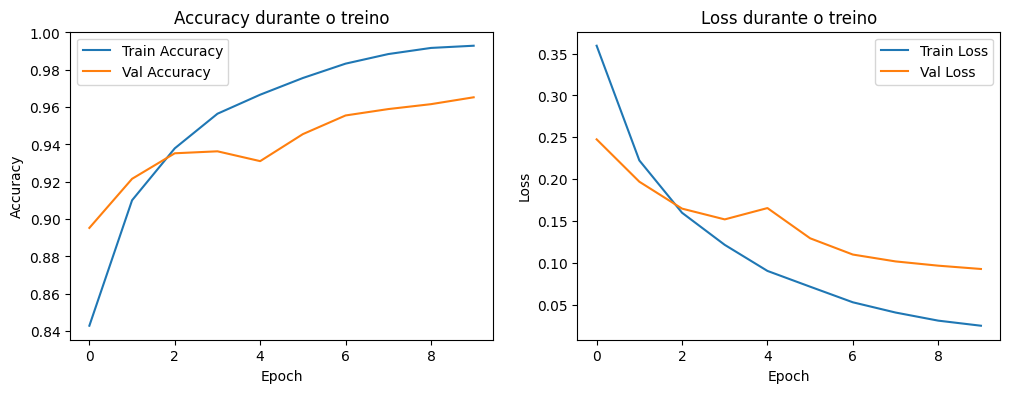

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy durante o treino')

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss durante o treino')

    plt.show()

plot_history(history_finetune)


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Obter todos os dados do val_dataset de forma otimizada
y_true = []
y_pred = []

for images, labels in val_dataset:
    preds = model.predict(images, verbose=0)
    y_true.extend(np.argmax(labels, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# Matriz de confusão
cm = confusion_matrix(y_true, y_pred)

# Classes detectadas
class_names = list(val_dataset.class_indices.keys())

# Plot com seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.tight_layout()
plt.show()

# Relatório de classificação
print("Relatório de Classificação:")
print(classification_report(y_true, y_pred, target_names=class_names))


KeyboardInterrupt: 

In [ ]:
# Carrega o modelo Keras
model = tf.keras.models.load_model("modelo_finetune_mosquitos.keras")

# Conversão
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Salvar arquivo .tflite
with open("modelo_mosquitos.tflite", "wb") as f:
    f.write(tflite_model)

print("✅ Modelo convertido e salvo como 'modelo_mosquitos.tflite'")


Saved artifact at '/tmp/tmpinnigq54'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_3')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  133141135434448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133141135433104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133141135429264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133141135432912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133141135434640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133138749209680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133141135429840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133141135426960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133138698503184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133141135427536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1331411354354

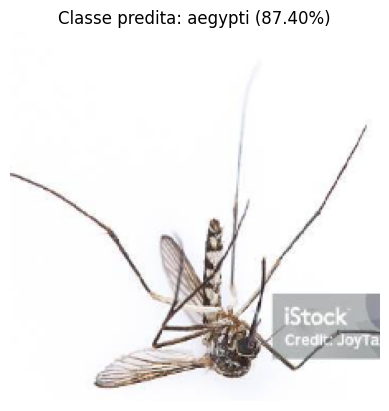

Probabilidades:
aegypti: 87.40%
albopictus: 12.60%
----------------------------------------


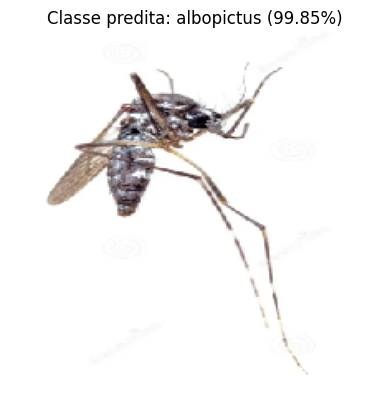

Probabilidades:
aegypti: 0.15%
albopictus: 99.85%
----------------------------------------


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Caminhos das imagens
caminho_imagem1 = "/teste_dengue.png"
caminho_imagem2 = "/teste_tigre.png"
img_size = (224, 224)

# Nome das classes
class_names = ['aegypti', 'albopictus']

# Função para pré-processar e prever uma imagem com o modelo TFLite
def prever_imagem(caminho_imagem, interpreter):
    # Carregar imagem e pré-processar
    img = tf.keras.preprocessing.image.load_img(caminho_imagem, target_size=img_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_preprocessed = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    img_expanded = np.expand_dims(img_preprocessed, axis=0).astype(np.float32)

    # Obter índices de entrada e saída
    input_index = interpreter.get_input_details()[0]['index']
    output_index = interpreter.get_output_details()[0]['index']

    # Executar predição
    interpreter.set_tensor(input_index, img_expanded)
    interpreter.invoke()
    output = interpreter.get_tensor(output_index)[0]

    # Interpretar resultado
    pred_class_index = np.argmax(output)
    pred_class_name = class_names[pred_class_index]

    # Mostrar imagem com predição
    plt.imshow(np.array(img).astype("uint8"))
    plt.title(f"Classe predita: {pred_class_name} ({output[pred_class_index]*100:.2f}%)")
    plt.axis('off')
    plt.show()

    # Mostrar probabilidades
    print("Probabilidades:")
    for i, class_name in enumerate(class_names):
        print(f"{class_name}: {output[i]*100:.2f}%")
    print("-" * 40)

# Carregar modelo TFLite
interpreter = tf.lite.Interpreter(model_path="modelo_mosquitos.tflite")
interpreter.allocate_tensors()

prever_imagem(caminho_imagem1, interpreter)
prever_imagem(caminho_imagem2, interpreter)


Found 19008 files belonging to 2 classes.

Classification Report:
              precision    recall  f1-score   support

     aegypti       0.97      0.74      0.84       100
  albopictus       0.79      0.98      0.88       100

    accuracy                           0.86       200
   macro avg       0.88      0.86      0.86       200
weighted avg       0.88      0.86      0.86       200



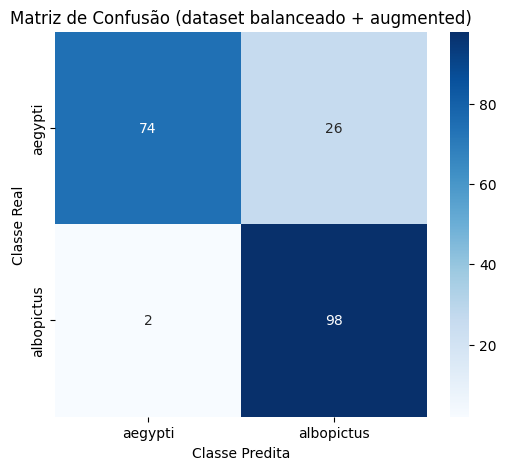

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Configurações
model_path = "modelo_mosquitos.tflite"
class_names = ['aegypti', 'albopictus']
img_size = (224, 224)
batch_size = 32
dataset_path = "/content/dataset_aedes/dataset-aedes"

full_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    image_size=img_size,
    batch_size=1,
    label_mode='categorical',
    shuffle=True,
    seed=123
)

max_images_per_class = 100
selected_images = []
selected_labels = []

counts = {0: 0, 1: 0}

for img, label in full_dataset.unbatch():
    class_idx = np.argmax(label.numpy())
    if counts[class_idx] < max_images_per_class:
        selected_images.append(img)
        selected_labels.append(label)
        counts[class_idx] += 1
    if all(v >= max_images_per_class for v in counts.values()):
        break

balanced_images = tf.stack(selected_images)
balanced_labels = tf.stack(selected_labels)
balanced_dataset = tf.data.Dataset.from_tensor_slices((balanced_images, balanced_labels))

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1)
])

def augment(x, y):
    x = tf.cast(x, tf.float32)
    x = data_augmentation(x)
    return x, y

augmented_dataset = balanced_dataset.map(augment).batch(batch_size)

def preprocess_mobilenet(x, y):
    x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
    return x, y

val_dataset = augmented_dataset.map(preprocess_mobilenet)

interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()
input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']

y_true = []
y_pred = []

for images, labels in val_dataset:
    images_np = images.numpy()
    labels_np = labels.numpy()
    for i in range(images_np.shape[0]):
        img = images_np[i:i+1]
        interpreter.set_tensor(input_index, img)
        interpreter.invoke()
        output = interpreter.get_tensor(output_index)

        y_true.append(np.argmax(labels_np[i]))
        y_pred.append(np.argmax(output[0]))

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Classe Predita")
plt.ylabel("Classe Real")
plt.title("Matriz de Confusão (dataset balanceado + augmented)")
plt.show()



Random Classifier - Classification Report:
              precision    recall  f1-score   support

     aegypti       0.51      0.56      0.53       100
  albopictus       0.51      0.46      0.48       100

    accuracy                           0.51       200
   macro avg       0.51      0.51      0.51       200
weighted avg       0.51      0.51      0.51       200



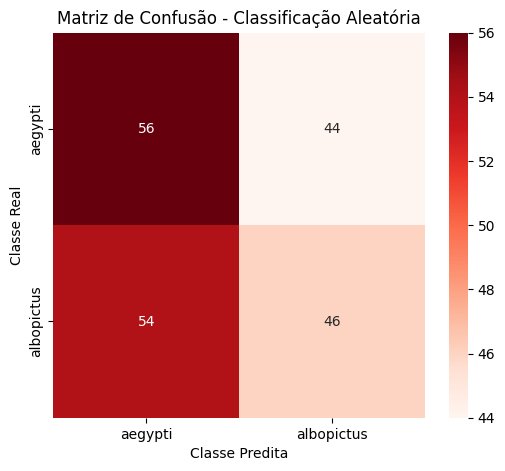

In [ ]:
import random
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

class_names = ['aegypti', 'albopictus']

y_true_random = y_true.copy()  # usa os verdadeiros rótulos do dataset

# Faz predição aleatória (escolha aleatória entre 0 e 1 para cada amostra)
y_pred_random = [random.choice([0,1]) for _ in y_true_random]

print("\nRandom Classifier - Classification Report:")
print(classification_report(y_true_random, y_pred_random, target_names=class_names))

# Matriz de confusão do random
cm_random = confusion_matrix(y_true_random, y_pred_random)
plt.figure(figsize=(6,5))
sns.heatmap(cm_random, annot=True, fmt="d", cmap="Reds",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Classe Predita")
plt.ylabel("Classe Real")
plt.title("Matriz de Confusão - Classificação Aleatória")
plt.show()
